In [1]:
# standard python utilities
import os
from os.path import join, basename, dirname, exists
import sys
import glob
import pandas as pd
import numpy as np
import time

# standard python plotting utilities
import matplotlib as mpl
import matplotlib.pyplot as plt

# standard geospatial python utilities
import pyproj # for converting proj4string
import shapely
import geopandas as gpd
from osgeo import gdal
import rasterio

# mapping utilities
import contextily as ctx
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm

In [2]:
doc_dir = os.getcwd()
while basename(doc_dir) != 'Documents':
    doc_dir = dirname(doc_dir)
# dir of all gwfm data
gwfm_dir = dirname(doc_dir)+'/Box/research_cosumnes/GWFlowModel'
gwfm_dir

'C:\\Users\\ajcalder/Box/research_cosumnes/GWFlowModel'

In [3]:
flopy_dir = doc_dir+'/GitHub/flopy/'
if flopy_dir not in sys.path:
    sys.path.append(flopy_dir)
# sys.path
import flopy 

# from importlib import reload
# # importlib.reload
# reload(flopy)


In [4]:
from flopy.utils.geometry import Polygon, LineString, Point
# New model domain 52.9 deg
m_domain = gpd.read_file(gwfm_dir+'/DIS_data/NewModelDomain/GWModelDomain_52_9deg_UTM10N_WGS84.shp')

# Need to check this when changing model domains
xul, yul = list(m_domain.geometry.values[0].exterior.coords)[1]
list(m_domain.geometry.values[0].exterior.coords)
# m_domain.geometry.values[0].exterior

[(645500.0, 4227700.0),
 (629548.3214234954, 4239764.159754906),
 (657295.8888597784, 4276453.020480867),
 (673247.567436283, 4264388.860725961),
 (645500.0, 4227700.0)]

In [5]:
sensors = gpd.read_file(gwfm_dir+"/DEM_data/allsensor_latlong.csv")
sensors.Latitude = sensors.Latitude.astype(np.float64)
sensors.Longitude = sensors.Longitude.astype(np.float64)
sensors.geometry = gpd.points_from_xy(sensors.Longitude, sensors.Latitude)
sensors.crs = 'epsg:4326'
sensors = sensors.to_crs('epsg:32610')

In [6]:
# import contextily as ctx
# fig, ax = plt.subplots(figsize = (10,10))
# mg.plot(ax=ax, alpha = 0.3)
# sensors.plot(ax =ax)

# ctx.add_basemap(ax, source = ctx.providers.Esri.WorldImagery, crs='epsg:26910', alpha = 0.6)
# # ctx.add_basemap(ax, source = ctx.providers.Esri.WorldStreetMap, crs=tg.crs.to_string())

# plt.xlabel('Easting (m)')
# plt.ylabel('Northing (m)')
# plt.savefig('Plots/Model_SFR_UZF_progress/Model_grid_overlay_satellite.png', dpi = 300)

In [9]:
# Load model grid as geopandas object
grid_p = gpd.read_file(gwfm_dir+'/DIS_data/grid/grid.shp')
# grid_p = gpd.read_file(gwfm_dir+'/DIS_data/44_7_grid/44_7_grid.shp')


# Find Michigan Bar location
mb_gpd = sensors[sensors.Sensor_id == "MI_Bar"]
mb_grid = gpd.sjoin(mb_gpd, grid_p, how = 'left', predicate = 'intersects')

### Raster files can be loaded using the `Raster.load` method

In [20]:
raster_name = gwfm_dir+"/DEM_data/USGS_ten_meter_dem/modeldomain_10m_transformed.tif"


In [11]:

# Based on Maribeth's grid aligned with Alisha's TPROGS model
# dem_data = np.loadtxt(gwfm_dir+'\DIS_data\dem_52_9_200m_nearest.tsv', delimiter = '\t')
dem_data = np.loadtxt(gwfm_dir+'\DIS_data\dem_52_9_200m_linear.tsv', delimiter = '\t')

# import seaborn as sns
# sns.heatmap(dem_data, cmap = 'viridis', vmin = 0)

<>:3: DeprecationWarning: invalid escape sequence '\D'
<>:3: DeprecationWarning: invalid escape sequence '\D'
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_126492\4006620616.py:3: DeprecationWarning: invalid escape sequence '\D'
  dem_data = np.loadtxt(gwfm_dir+'\DIS_data\dem_52_9_200m_linear.tsv', delimiter = '\t')


## Import soil data for Lake Package, UZF Package, SFR Package hydraulic parameters

In [12]:
uzf_dir = gwfm_dir+'\\UZF_data'


In [13]:
grid_uzf = gpd.read_file(uzf_dir+'/final_grid_uzf/griduzf.shp')

In [14]:
soil_dir = join(uzf_dir, 'final_soil_arrays')
soilKs_array = np.loadtxt(soil_dir+'/final_soilKs.tsv', delimiter = '\t')
soiln_array = np.loadtxt(soil_dir+'/final_soiln.tsv', delimiter = '\t')
soileps_array = np.loadtxt(soil_dir+'/final_soileps.tsv', delimiter = '\t')


# SFR

In [15]:
sfr_dir = gwfm_dir+'/SFR_data/'

C:\Users\ajcalder\Anaconda3\envs\geo_env\lib\site-packages\geopandas\tools\clip.py:67: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


<Axes: >

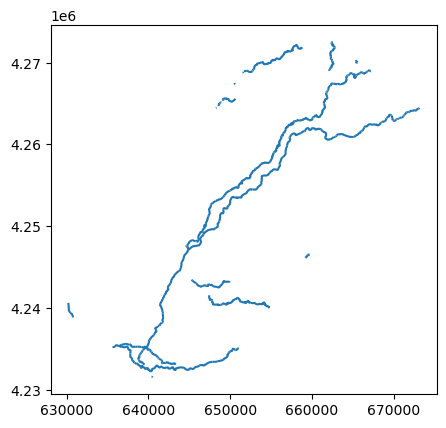

In [16]:

# Rivers and creeks in the larger area encompassing Cosumnes River in both South American and Cosumnes Subbasins
rivers = gpd.read_file(gwfm_dir+"/SFR_data/Sac_valley_rivers/Sac_valley_rivers.shp")

rivers = rivers.to_crs('EPSG:32610')
rivers_clip = gpd.clip(rivers, m_domain)
rivers_clip.plot()
# rivers_clip.GNIS_Name.unique()

In [17]:
print(rivers_clip.columns)
# Split into individual streams/creeks
cr_ind = rivers_clip[rivers_clip.GNIS_Name == 'Cosumnes River']
dc_ind = rivers_clip[rivers_clip.GNIS_Name == 'Deer Creek']
cc_ind = rivers_clip[rivers_clip.GNIS_Name ==  'Coyote Creek']
# Pull out data for each river/creek
cr = rivers_clip.loc[cr_ind.index,]
dc = rivers_clip.loc[dc_ind.index,]
cc = rivers_clip.loc[cc_ind.index,]


Index(['OBJECTID', 'Permanent_', 'FDate', 'Resolution', 'GNIS_ID', 'GNIS_Name',
       'LengthKM', 'ReachCode', 'FlowDir', 'WBArea_Per', 'FType', 'FCode',
       'MainPath', 'InNetwork', 'Visibility', 'Shape_Leng', 'Enabled',
       'geometry'],
      dtype='object')


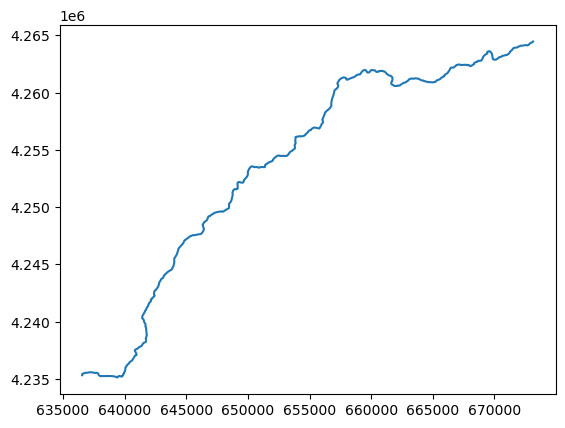

In [18]:
import fiona
from shapely.geometry import shape, mapping
from shapely.ops import linemerge

geom = linemerge(cr.geometry.unary_union)
# how often to interpolate a point
dline = 10
# # length of the LineString
length = int(geom.length)
point = np.zeros((int(length/dline)+1,3))
for i, distance in enumerate(range(0, int(length), dline)):
         point[i,:] = geom.interpolate(distance).coords[:][0]
point = point[:,[0,1]]
plt.plot(point[:,0],point[:,1])


In [21]:

# dem10 = rasterio.open(raster_name)

pnts = pd.DataFrame()
with rasterio.open(raster_name) as src:
    pnts['z'] = [sample[0] for sample in src.sample(point)]
pnts
pnts['easting'] = point[:,0]
pnts['northing'] = point[:,1]
pnts = pnts[pnts.z > -1E4]



<Axes: >

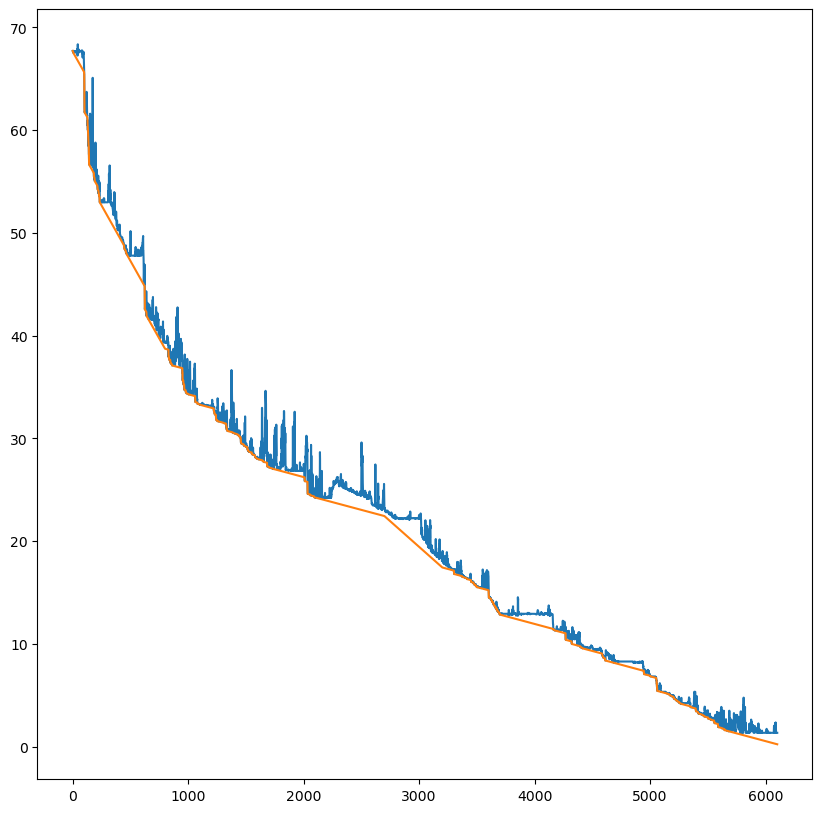

In [22]:
plt.figure(figsize = (10,10))
pnts.z.plot()
pnts['slope'] = 0.002
for i in np.arange(1,len(pnts)):
    if pnts.z.values[i] >= pnts.z.values[i-1]:
        # if strtop is greater than previous strtop use previous elevation minus the average slope
        slope = ((np.max(pnts.z) - np.min(pnts.z))/geom.length)*dline
        if pnts.index[i] < 800:
            slope = 0.002
        elif pnts.index[i] < 2700:
            slope = 0.0003
        elif pnts.index[i] < 3200:
            slope = 0.001
        else:
            slope = 0.0003
        pnts.z.values[i] = pnts.z.values[i-1] - slope*dline
        pnts.slope.values[i] = slope
pnts.z.plot()

In [23]:
pnts['Point_order'] = pnts.index

In [24]:
pnts_gpd = gpd.GeoDataFrame(pnts, geometry = gpd.points_from_xy(pnts.easting, pnts.northing))
pnts_gpd.crs = 'epsg:32610'

In [61]:
# # Samples the points every 10 meters to match with the 100 meter grid
grid_sfr = gpd.sjoin(grid_p, pnts_gpd, how = "inner", predicate= "intersects")


# # Set reach length for each reach based on the separation used to create the points from the line object
# # dline is 10 meters
grid_sfr['length_m'] = dline

# Dissolve the points again but using sum this time to get the total length of each reach
length_m = grid_sfr.dissolve(by = 'node', aggfunc = 'sum').length_m.values
# approximate the thalweg of each segment
min_z = grid_sfr.dissolve(by = 'node', aggfunc = 'min').z.values

# Dissolves the points every 10 meters to the 200 meter spacing, using mean because the interested component is elevation
grid_sfr = grid_sfr.dissolve(by = 'node', aggfunc = 'mean')
grid_sfr['length_m'] = length_m
grid_sfr['z_min'] = min_z

grid_sfr = grid_sfr.sort_values(by = 'Point_order')
grid_sfr['reach'] = np.arange(1,len(grid_sfr)+1)
grid_sfr['dist_m'] = grid_sfr.length_m.cumsum()

# only keep cells with segments greater than 100m long to reduce computation time
# and as short segments should contribute less seepage and it creates a more continuous line
grid_sfr_final = grid_sfr[grid_sfr.length_m>100]

<Axes: >

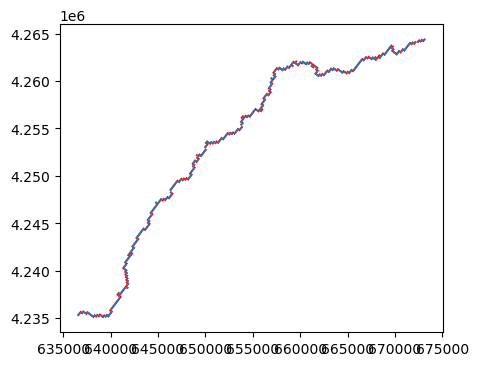

In [43]:
fig,ax=plt.subplots(figsize=(6,4))
grid_sfr.plot(ax=ax, color='red')
grid_sfr_final.plot(ax=ax)

In [434]:
# grid_sfr.to_file(sfr_dir+'/final_grid_sfr/grid_sfr.shp')
# grid_sfr = gpd.read_file(sfr_dir+'/final_grid_sfr/grid_sfr.shp')


In [435]:
# floodplain sensor info
fp_sensors = gpd.read_file(gwfm_dir+"/LAK_data/floodplain_logger_metadata.csv", header = True)
fp_sensors.Northing = fp_sensors.Northing.astype(np.float64)
fp_sensors.Easting = fp_sensors.Easting.astype(np.float64)
fp_sensors.geometry = gpd.points_from_xy(fp_sensors.Easting, fp_sensors.Northing)
fp_sensors.crs = 'epsg:32610'

In [436]:
# od_breach is the sensor location where the breach was made in the levees for flow to leave the river
od_breach = fp_sensors[fp_sensors['Logger Location']=='OD_Excavation']
od_breach


,Logger Location,Logger Type,Easting,Northing,Elevation,Solinst Logger Serial Number 2012,Solinst Logger Serial Number 2013,Solinst Logger Serial Number 2014,Solinst Logger Serial Number 2015,Solinst Logger Serial Number 2016,geometry
2,OD_Excavation,Breach,641763.495,4241361.24,6.597,,,,32037867,21052169,POINT (641763.495 4241361.240)


In [437]:
# first need to try with just adding extra cross section
# append the extra reach to the list of reaches and resort by reach
# grid_sfr = grid_sfr.append(grid_breach).sort_values(by = 'reach')
# # next, need to relabel reaches to account for the added reach witha duplicate number
# grid_sfr.reach = np.arange(1,len(grid_sfr)+1)
# grid_sfr

In [438]:
# # Buffer the location of the breach sensor to have overlap with the river streamline
# just sjoin the geometry because the extra info is unnecessary
# spatial join breach sensor polygon with sfr grid locations to find match
grid_breach = gpd.sjoin(grid_sfr, 
                        gpd.GeoDataFrame(geometry = od_breach.geometry.buffer(25), crs = 'epsg:32610'), how = "inner", op= "intersects")
# add a reach to the overlap cell that will be used to divert flow (there will be two reaches in one cell)
grid_breach

,node,row,column,index_righ,z,easting,northing,slope,Point_orde,length_m,reach,geometry,index_right
292,10164,45.0,44.0,4994.0,6.838629,641880.440454,4.241351e+06,0.0003,4994.0,210,293,"POLYGON ((641754.648 4241315.151, 641875.290 4...",2


In [439]:
XS8pt = pd.read_csv(sfr_dir+'8pointXS.csv')
XSlocs = gpd.read_file(sfr_dir+'8pointXS_locs\\8pointXS_locs.shp')
XSlocs.crs = 32610

XSg  = gpd.sjoin(grid_sfr, XSlocs, how = "inner", op= "contains", lsuffix = 'sfr',rsuffix = 'xs')
# Append the grid_breach location to the list of cross sections to split the segment
XSg = XSg.append(grid_breach).sort_values('reach')
# Copy the XS site name from the previous last site to the breach site to keep same XS
XSg.Site.iloc[-1] = XSg.Site.iloc[-2]
len(XSg), len(XS8pt.loc[0,:])/2

C:\Users\ajcalder\anaconda3\envs\geosp\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


(29, 30.0)

### Read in 8 pt XS, revised by simplifying from Constantine 2001

In [440]:
# There is one reach for each cell that a river crosses
NSTRM = -len(grid_sfr)
# There should a be a stream segment if there are major changes
# in variables in Item 4 or Item 6
# 1st segment is for the usgs Michigan Bar rating curve, one for each XS, plus 2 for the floodplain diversion
NSS = 1 + len(XSg) 
# nparseg (int) number of stream-segment definition with all parameters, must be zero when nstrm is negative
NPARSEG = 0
CONST = 86400 # mannings constant for SI units, 1.0 for seconds, 86400 for days
# real value equal to the tolerance of stream depth used in
# computing leakage between each stream reach and active model cell
DLEAK = 0.0001 # unit in lengths, 0.0001 is sufficient for units of meters
IPAKCB = 55
# writes out stream depth, width, conductance, gradient when cell by cell
# budget is specified and istcb2 is the unit folder
ISTCB2 = 54
# specifies whether unsat flow beneath stream or not, isfropt 2 has properties read for each reach, isfropt 3 also has UHC
# read for each reach, isfropt 4 has properties read for each segment (no UHC), 5 reads for each segment with UHC
ISFROPT = 1
# nstrail (int), number of trailing weave increments used to represent a trailing wave, used to represent a decrease 
# in the surface infiltration rate. Can be increased to improve mass balance, values between 10-20 work well with error 
# beneath streams ranging between 0.001 and 0.01 percent, default is 10 (only when isfropt >1)
NSTRAIL = 20
# isuzn (int) tells max number of vertical cells used to define the unsaturated zone beneath a stream reach (default is 1)
ISUZN = 1
#nsfrsets (int) is max number of different sets of trailing waves (used to allocate arrays), a value of 30 is sufficient for problems
# where stream depth varies often, value doesn't effect run time (default is 30)
NSFRSETS = 30
# IRTFLG (int) indicates whether transient streamflow routing is active, must be specified if NSTRM <0. If IRTFLG >0 then
# flow will be routed with the kinematic-wave equations, otherwise it should be 0 (only for MF2005), default is 1
IRTFLG = 1
# numtim (int) is number of sub time steps used to route streamflow. Streamflow time step = MF Time step / NUMTIM. 
# Default is 2, only when IRTFLG >0
NUMTIM = 4
# weight (float) is a weighting factor used to calculate change in channel storage 0.5 - 1 (default of 0.75) 
WEIGHT = 0.75
# flwtol (float), flow tolerance, a value of 0.00003 m3/s has been used successfully (default of 0.0001)
FLWTOL = 0.0001

sfr = flopy.modflow.ModflowSfr2(model = m, nstrm = NSTRM, nss = NSS, nparseg = NPARSEG, 
                           const = CONST, dleak = DLEAK, ipakcb = IPAKCB, istcb2 = ISTCB2, 
                          isfropt = ISFROPT, nstrail = NSTRAIL, isuzn = ISUZN, irtflg = IRTFLG, 
                          numtim = NUMTIM, weight = WEIGHT, flwtol = FLWTOL,
                                reachinput=True, transroute=True, tabfiles=True,
                                tabfiles_dict={1: {'numval': nper, 'inuit': 56}})

In [441]:
# Add option block at the top of the sfr input file for tabfiles
tab_option = flopy.utils.OptionBlock(options_line = ' reachinput transroute tabfiles 1 ' + str(nper), package = sfr, block = True)
sfr.options = tab_option
# sfr.options

In [442]:
# Modflow NWT additions to SFR package set up
# sfr.transroute = True
# sfr.reachinput = True
# sfr.tabfiles = True
# # numval is the number of values in the flow tab files, inuit is the corresponding unit file
# sfr.tabfiles_dict = {1: {'numval': nper, 'inuit': 56}}

In [443]:
xs_sfr = grid_sfr.set_index('reach')
# set all reaches to start as segment 1 which will be changed iteratively based on the number of cross-sections
xs_sfr['iseg'] = 1
# add a column reach_new that will be changed iteratively as the segment number is changed
xs_sfr['reach_new'] = xs_sfr.index
# xs_sfr

## Define reach data based on ISFROPT

In [444]:
## Given the reach number of each XS, the 718 reaches will be broken down into each segment
## create a new reach column based on XS reach number and 

segcount = 2
for i in np.arange(0,len(XSg)):
    temp_reach = XSg.reach.values[i]
    rchnum = xs_sfr.index[-1] - temp_reach+1
    xs_sfr.reach_new.loc[temp_reach:] = np.linspace(1,rchnum, rchnum)
    xs_sfr.iseg.loc[temp_reach:] = segcount
    segcount +=1

In [445]:
xs_sfr.reach_new = xs_sfr.reach_new.astype(int)


In [446]:
# Determine which layer the streamcell is in
# since the if statement only checks whether the first layer is greater than the streambed elevation, 
# otherwise it would be less than and zero (most should be in layer 0)
sfr_lay = np.zeros(len(grid_sfr))

for i in np.arange(0,nlay-1):
    # pull out elevation of layer bottom
    lay_elev = botm[i, (grid_sfr.row.values-1).astype(int), (grid_sfr.column.values-1).astype(int)]
    for j in np.arange(0,len(grid_sfr)):
        # want to compare if streambed is lower than the layer bottom
        # 1 will be subtracted from each z value to make sure it is lower than the model top in the upper reaches
        if lay_elev[j] < (grid_sfr.z.values-1)[j]:
            sfr_lay[j] = i 
        


In [447]:
# KRCH, IRCH, JRCH, ISEG, IREACH, RCHLEN, STRTOP, SLOPE, STRTHICK, STRHC1, THTS, THTI, EPS, UHC

columns = ['KRCH', 'IRCH', 'JRCH', 'ISEG', 'IREACH', 'RCHLEN', 'STRTOP', 
               'SLOPE', 'STRTHICK', 'STRHC1', 'THTS', 'THTI', 'EPS', 'UHC']

sfr.reach_data.node = grid_sfr.index
sfr.reach_data.k = sfr_lay.astype(int)
sfr.reach_data.i = grid_sfr.row.values-1
sfr.reach_data.j = grid_sfr.column.values-1
sfr.reach_data.iseg = xs_sfr.iseg
sfr.reach_data.ireach = xs_sfr.reach_new
sfr.reach_data.rchlen = xs_sfr.length_m.values
sfr.reach_data.strtop = grid_sfr.z.values-1
sfr.reach_data.slope = grid_sfr.slope.values
sfr.reach_data.strthick = 2 # guess 2 meters thick streambed
# 0.004125 m/s average which is 356.4266 m/d
sfr.reach_data.strhc1 = soilKs_array[sfr.reach_data.i, sfr.reach_data.j]
sfr.reach_data.thts = soiln_array[sfr.reach_data.i, sfr.reach_data.j]
sfr.reach_data.thti = sfr.reach_data.thts
sfr.reach_data.eps = soileps_array[sfr.reach_data.i, sfr.reach_data.j]


In [448]:
mb4rl = pd.read_csv(sfr_dir+'michigan_bar_icalc4_data.csv', skiprows = 0, sep = ',')
# mb4rl.plot(x='gage_height_va',y='discharge_va', legend = False)
# plt.xlabel('Gage height (m)')
# plt.ylabel('Discharge $(m^3/d$)')
# plt.ticklabel_format(style='scientific') # plain to show all zeros
# plt.title('Simplified USGS Michigan Bar Rating Curve')
# plt.savefig('Plots/Model_SFR_UZF_Progress/MB_ratingcurve', dpi = 300, bbox_inches='tight')

## Define segment data

Median grain size (mm) ranges from 1 mm – 30 mm along surveyed sites, which gives a range of 0.026-0.035 for a stable channel
Moderate channel irregularity due to channel scouring and pools alternating, range of 0.006-0.010
Gradual cross section change: 0.000 adjustment
Effect of obstructions: minor due to occasional downed logs and debris in river, 0.005-0.015
Amount of vegetation: large on banks due to willows and cottonwood trees, 0.025-0.050, and negligible in the channel
Degree of meandering: minor due to levees, m = 1.0

n = (nb+n1+n2+n3+n4)*m (b=base,1=surface irregularity, 2 = XS variation, 3 = obstructions, 4 = vegetation, m = correction for meandering)
n = (0.03+0.08+0.01) = 0.048 in channel
n = (0.048 +0.03) = 0.078 on banks


In [449]:
# There is one dictionary key for each stress period (starting at 0) and in each dictionary key there is a 
# rec array holding an entry for each stream segment where nseg shows which segment it is (ie no dictionary key for segment)
# If ITMP = 0 Item 4 is used, if ITMP >0 Item 6 is used, 
# if ITMP <0 the stream segment data not defined in Item 4 will be reused form the last stress period
nss = NSS
if sfr.dataset_5[0][0] > 0 :
    # For the first stress period
    t = 0
    for i in np.arange(0, nss):
        # Section 6a
        sfr.segment_data[t][i].nseg = int(i)+1
        if sfr.segment_data[t][i].nseg ==1:
            sfr.segment_data[t][i].icalc = 4
        else:
            sfr.segment_data[t][i].icalc = 2 # Mannings and 8 point channel XS is 2 with plain MF, 5 with SAFE
        if sfr.segment_data[t][i].nseg != nss:
            sfr.segment_data[t][i].outseg =sfr.segment_data[t][i].nseg +1
        elif sfr.segment_data[t][i].nseg == nss:
            sfr.segment_data[t][i].outseg = 0
        if sfr.segment_data[t][i].nseg != 1:
            sfr.segment_data[t][i].iupseg =sfr.segment_data[t][i].nseg - 1
            # Integer value that defines priority for diversion
            sfr.segment_data[t][i].iprior = -2 #diversion made will max out at flow in channel leaving no flow in channel
        elif sfr.segment_data[t][i].nseg ==1:
            sfr.segment_data[t][i].iupseg = 0
        if sfr.segment_data[t][i].icalc ==4:
            sfr.segment_data[t][i].nstrpts = len(mb4rl)
        # Defined 
        if sfr.segment_data[t][i].nseg != 1:
            sfr.segment_data[t][i].flow= 1
        elif sfr.segment_data[t][i].nseg ==1:
            sfr.segment_data[t][i].flow= 2.834*86400. # m3/day, originally 15 m3/s
        sfr.segment_data[t][i].runoff = 0.0
        sfr.segment_data[t][i].etsw = 0.01
        sfr.segment_data[t][i].pptsw = 0.01
        # Manning's n data comes from Barnes 1967 UGSS Paper 1849 and USGS 1989 report on selecting manning's n
        # RoughCH is only specified for icalc = 1 or 2
        if sfr.segment_data[t][i].icalc == 1 or sfr.segment_data[t][i].icalc ==2:
            sfr.segment_data[t][i].roughch = 0.048
        # ROUGHBK is only specified for icalc = 2
        if sfr.segment_data[t][i].icalc == 2 or sfr.segment_data[t][i].icalc == 5:
            sfr.segment_data[t][i].roughbk = 0.083 # higher due to vegetation
            
            
# Define stress period data need one for each stress period
# Dataset 5 will be built automatically from segment_data unless specified
# ITMP (int) for reusing or reading stream seg data that can change each stress period
#IRDFLG, 0 is input data printed, greater than 0 input data is not printed
# doesn't seem to change the value
# IPTFLG, 0 is streamflow-routing results printed, greater than 0 not

In [450]:
# Pull out data for upstream and downstream reach of each segment
up_data = xs_sfr.drop_duplicates('iseg')
dn_data = xs_sfr.sort_values('reach_new',ascending = False).drop_duplicates('iseg').sort_values('iseg')


# Need to return to later and remove hard coding
# These are getting used for initial guesses
# Read in first stress period when ICALC = 1 or 2 and ISFROPT is 5
# Dataset 6b
sfr.segment_data[0].hcond1 = sfr.reach_data.strhc1[0]
sfr.segment_data[0].thickm1 = 2
sfr.segment_data[0].elevup = up_data.z.values
sfr.segment_data[0].width1 = 20
sfr.segment_data[0].depth1 = 1
sfr.segment_data[0].thts1 = 0.4
sfr.segment_data[0].thti1 = 0.15
sfr.segment_data[0].eps1 = 4
sfr.segment_data[0].uhc1 = sfr.reach_data.strhc1[0]

# Dataset 6c
sfr.segment_data[0].hcond2 = sfr.reach_data.strhc1[-1]
sfr.segment_data[0].thickm2 = 2
sfr.segment_data[0].elevdn = dn_data.z.values
sfr.segment_data[0].width2 = 20
sfr.segment_data[0].depth2 = 1
sfr.segment_data[0].thts2 = 0.4
sfr.segment_data[0].thti2 = 0.15
sfr.segment_data[0].eps2 = 4
sfr.segment_data[0].uhc2 = sfr.reach_data.strhc1[-1]


In [451]:
# Change column name to float type for easier referencing in iteration
XS8pt.columns = XS8pt.columns.astype('float')
# Pre-create dictionary to be filled in loop
sfr.channel_geometry_data = {0:{j:[] for j in np.arange(2,len(XSg)+2)}  }

xsnum = 2
for k in XSg.Site.values:
        pos = int(XS8pt.columns.get_loc(k))
        XCPT = XS8pt.iloc[:,pos].values
        ZCPT = XS8pt.iloc[:,pos+1].values
        ZCPT_min = np.min(ZCPT)
        ZCPT-= ZCPT_min
        sfr.channel_geometry_data[0][xsnum] = [XCPT, ZCPT]
        xsnum += 1


In [452]:
FLOWTAB = mb4rl.discharge_va.values
DPTHTAB = mb4rl.gage_height_va.values
WDTHTAB = mb4rl.chan_width.values
sfr.channel_flow_data = {0: {1: [FLOWTAB, DPTHTAB, WDTHTAB]}}

In [453]:
# sfr.plot_path(start_seg=1, end_seg=0, plot_segment_lines=True)
# plt.savefig('Plots/Model_SFR_UZF_Progress/sfr_elev_vs_model_top.png', dpi = 600, bbox_inches='tight')

## Tabfile set up for SFR


In [555]:
# For the tab files the left column is time (in model units) and the right column is flow (model units)
# Time is days, flow is cubic meters per day
import numpy as np
import pandas as pd
# USGS presents flow in cfs (cubic feet per second)
inflow = pd.read_csv(sfr_dir+'MB_daily_flow_cfs_2011_2019.csv', index_col = 'datetime', parse_dates = True)

# filter out data between the stress period dates
inflow = inflow.loc[strt_date:end_date]
# covnert flow from cubic feet per second to cubic meters per day
inflow['flow_cmd'] = inflow.flow_cfs * (86400/(3.28**3))

# # np.arange(0,len(flow_cmd))
time_flow = np.vstack((np.arange(0,len(inflow.flow_cmd)),inflow.flow_cmd))
time_flow = np.transpose(time_flow)
np.savetxt('data/MF.tab',time_flow, delimiter = '\t')

In [556]:
# the threshold is 23m^3/s
23*(86400)/1e6, inflow.flow_cmd.min(), inflow.flow_cmd.mean(),inflow.flow_cmd.median()

(1.9872, 33543.840048751474, 1680346.8205507481, 340335.3114435369)

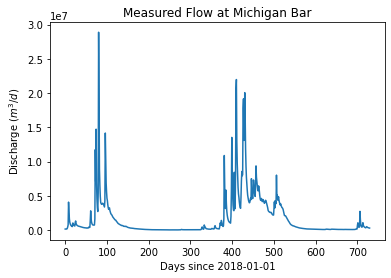

In [557]:
plt.plot(time_flow[:,0],time_flow[:,1])
plt.xlabel('Days since '+strt_date)
plt.ylabel('Discharge ($m^3/d)$')
plt.title('Measured Flow at Michigan Bar')
plt.ticklabel_format(style='scientific') # or plain for all zeros

# plt.savefig('Plots/Model_SFR_UZF_Progress/dailyflow_MB.png', dpi = 300, bbox_inches='tight')

### Add the outside TAB file for SFR Package

In [558]:
# Only needs to be run one time
flopy.modflow.mfaddoutsidefile(model = m, name = 'DATA',extension = 'tab',unitnumber = 56)

Outside Package class

### Lake Bathymetry file set up

   OID_   Shape_Leng    Shape_Area  HydroID  MaxElev  MinElev  UserElev  \
0     0  9453.899233  2.078432e+06     2137  11.5702   2.9779       0.0   

                                            geometry  
0  POLYGON ((642539.493 4242823.298, 642529.571 4...  
The minimum lake stage is 4.83234365913772 m at which there is no water ponding


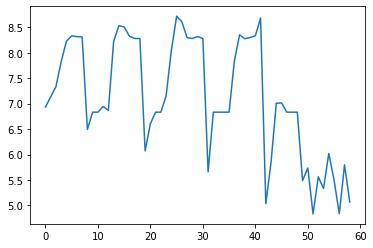

In [559]:
# Exactly 151 lines must be included within each lake bathymetry input file and each line must contain 1 value 
#  of lake stage (elevation), volume, and area (3 numbers per line) if the keyword “TABLEINPUT” is specified in item 1a.
# A separate file is required for each lake. 
# For oneto-denier, the levees are relatively vertical and on the very most exterior such that the lake area changes
# very litle for any change in stage
# It may be of interest to subset the lakes to have varying elevaion

# the initial stage of each lake at the beginning of the run
lak_elev = dem_data[gplak2D.row-1, gplak2D.column-1]
# minimum elevation based on resampled model dem because lake stage shouldn't be below the lowest cell
lak_elev_min = np.min(lak_elev)
# maximum stage based on data from the 2m DEM because max stage shouldn't be above the levees and
# the model dem doesn't capture the effect of the levees
lak_elev_max = lak2D.MaxElev.values[0]
stages = lak_elev_min+0.1
# (ssmn, ssmx) max and min stage of each lake for steady state solution, there is a stage range for each lake
# so double array is necessary
stage_range = [[lak_elev_min, lak_elev_max]]
print(lak2D)
# gplak2D
plt.plot(dem_data[gplak2D.row-1, gplak2D.column-1])
print('The minimum lake stage is', np.min(dem_data[gplak2D.row-1, gplak2D.column-1]), 
      'm at which there is no water ponding')



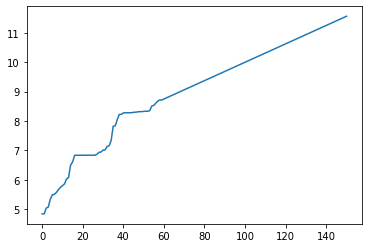

In [560]:
# for i in np.arange(0,151):
np.sort(lak_elev)
len(lak_elev)
lak_stage = np.append(np.sort(lak_elev), np.linspace(np.max(lak_elev),lak_elev_max, num = 151-len(lak_elev)))
plt.plot(lak_stage)

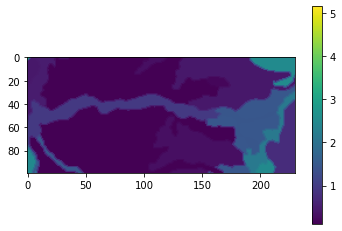

In [561]:
# nonzero = lakarr > 0
# bdlknc = np.zeros((nrow,ncol))
temp = np.zeros((nper, nlay, nrow,ncol))
# Calculate bed leakance based on soil maps K representative values
# temp[:,:, grid_uzf.row.values-1,grid_uzf.column.values-1] = grid_uzf.Ksat_Rep.values
temp[:,:,:] = soilKs_array
bdlknc = temp[0,:,:,:]

bdlknc.shape
plt.imshow(bdlknc[0,:,:])
plt.colorbar()
# lak.bdlknc.array.shape

## Create the bathymetry file for the LAK package

Becase the grid resolution is so coarse, there are both levee and floodplain cells in each grid cell that lead to the nearest cell being sampled to be of a much higher elevation than expected

In [562]:
# lake stage (elevation), volume, and area (3 numbers per line)
# for i in np.arange(0,151):
np.sort(lak_elev)
len(lak_elev)
lak_stage = np.append(np.sort(lak_elev), np.linspace(np.max(lak_elev),lak_elev_max, num = 151-len(lak_elev)))
lak_depth = lak_stage - lak_stage[0]
lak_area = np.arange(0,len(lak_elev))*(200*200)
lak_area = np.append(lak_area, lak_area[-1]*np.ones(len(lak_stage) - len(lak_area)))
lak_volume = lak_depth*lak_area
bathtxt = np.column_stack((lak_stage, lak_volume, lak_area))
# lak_area[-1]/1e6, lak2D
# plt.plot(lak_stage)
# for i in np.arange(0,len(lak_stage)):
np.savetxt('data/MF.txt', bathtxt, delimiter = '\t')

In [563]:
## Need to specify flux data
# Dict of lists keyed by stress period. The list for each stress period is a list of lists,
# with each list containing the variables PRCPLK EVAPLK RNF WTHDRW [SSMN] [SSMX] from the documentation.
# flux_data = np.zeros((nrow,ncol))

flux_data = {0:{0:[0,0,0,0]}}

In [564]:
# filler value for bdlknc until soil map data is loaded by uzf
lak = flopy.modflow.ModflowLak(model = m, lakarr = lakarr, bdlknc = bdlknc,  stages=stages, 
                               stage_range=stage_range, flux_data = 0,tabdata= True, 
                               tab_files='MF.txt', tab_units=57)

In [565]:
lak.tabdata = True
lak.iunit_tab


57

In [566]:
# the lak package doesn't specify the tab file unit number when the files are written
# example:      110.0     100.0     170.0   22   Item 3:  STAGES,SSMN,SSMX,IUNITLAKTAB

lak.options = ['TABLEINPUT']
# option block is not yet available for the lake package
# lak_option = flopy.utils.OptionBlock(options_line = 'TABLEINPUT ', package = lak, block = True)


### Add the outside bathymetry text file for LAK package

In [567]:
flopy.modflow.mfaddoutsidefile(model = m, name = 'DATA',extension = 'txt',unitnumber = 57)

Outside Package class